# 1. 패키지 및 원 자료 로드

In [1]:
# for viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
%matplotlib inline

# for preprocessing
import warnings
warnings.filterwarnings('ignore')
import os, sys
import numpy as np
import pandas as pd
from datetime import datetime 
import scipy
import random
import math
from scipy.stats.mstats import winsorize
from tqdm import tqdm

# oversampling & preprocessing & cv
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm

from sklearn.metrics import fbeta_score, make_scorer, matthews_corrcoef, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from collections import  Counter
import statsmodels.api as sm

# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS, RFE, SelectFromModel

# 2. 데이터 전처리

In [2]:
df = pd.read_csv('./dataset/marketing_campaign.csv',sep='\t')
df = df.dropna(axis=0)

# Drop constant columns - Z_CostContact & Z_Revenue
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True) 

# User ID is useless for classification & Segmentation task
df.drop(['ID'], axis=1, inplace=True) 

- Income 변수 결측치 제거 및 ID, constant variable column 제거. 

In [3]:
# Change Year_Birth to Age (Age is more informative)
df['Age'] = 2021 - df.Year_Birth.to_numpy()
df.drop('Year_Birth', axis=1, inplace=True)

- 'Year_Birth' 변수 사용해 'Age' 변수 생성 

In [4]:
index_ab = df[df['Marital_Status']=='Absurd'].index
index_YOLO = df[df['Marital_Status']=='YOLO'].index

df.drop(index_ab, inplace=True)
df.drop(index_YOLO, inplace=True)

df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner",
                                                "Widow":"Alone", "Divorced":"Alone", "Single":"Alone",})

df.drop('Marital_Status', axis=1, inplace=True)

- Marital_Status 변수에서 'Absurd'와 'YOLO' 제거하고, Partner 유무에 대한 이진 범주화.

In [6]:
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate",
                                         "Graduation":"Graduate",
                                         "Master":"Postgraduate", "PhD":"Postgraduate"})

- Education 변수의 범주별 빈도를 고려하여 3가지 범주로 축약

In [7]:
df.drop(df[(df['Income']>300000)|(df['Age']>100)].index,inplace=True)

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

bins = [df['Dt_Customer'].min(),df['Dt_Customer'].quantile(0.25), df['Dt_Customer'].quantile(0.75),df['Dt_Customer'].max()]
labels = ['long','normal','recent']
cuts = pd.cut(df['Dt_Customer'], bins, right=True, labels=labels)

df['Dt_Customer'] = cuts

- Income과 Age 변수의 이상치 제거 및 Dt_Customer 변수 long, normal, recent로 범주화.

In [8]:
df["Children"]=df["Kidhome"]+df["Teenhome"]
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

df['Living_With'] = np.where(df.Living_With=='Partner', 1, 0)

df=pd.get_dummies(df)

- 파생 변수 생성 및 dummy variable로 변환.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Response', axis=1), df['Response'], test_size=0.3, random_state=20211126)
print('Train: ', len(x_train))
print('Test: ',  len(x_test))
print('N/P Sample: ', Counter(y_train))

Train:  1545
Test:  663
N/P Sample:  Counter({0: 1305, 1: 240})


- 성능 평가를 위한 train/test set 분할

In [10]:
1305/1545

0.8446601941747572

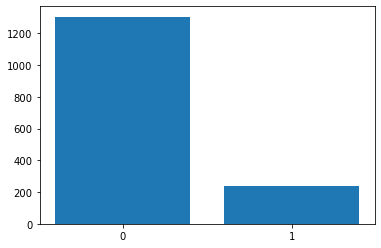

In [11]:
data = dict(Counter(y_train))
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

- train 자료의 약 84.47%가 'respose'에 1을 답하였다. 캠페인에 찬성한 의견에 대해서 학습하기 어려울 수 있음. 

In [12]:
pd.set_option('display.max_columns', None)  
x_train.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Age', 'Living_With', 'Children',
       'Family_Size', 'Is_Parent', 'Education_Graduate',
       'Education_Postgraduate', 'Education_Undergraduate', 'Dt_Customer_long',
       'Dt_Customer_normal', 'Dt_Customer_recent'],
      dtype='object')

- 범주형 변수들 각각 1,0으로 선형 종속 자명.

In [14]:
# min-max scaler 이용
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled = pd.DataFrame(x_train_scaled)
x_test_scaled = pd.DataFrame(x_test_scaled)

- MinMaxScaler: 모든 feature 값이 0~1사이에 있도록 데이터를 재조정한다. 이상치에 대해서 제거 해주었기 때문에, 크게 영향을 끼치지 않을 것이라 판다. 범주형 변수들에 대해서도 한번에 고려가 가능하다는 장점 반영

- 추후 거리 개념을 통해 자료를 재 생성하고, 분류하는 method를 위해서, 기본적인 minmaxscaler 적용. 최댓값 1, 최솟값 0으로

In [15]:
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,0.216335,0.5,0.0,0.333333,0.008038,0.000000,0.000580,0.000000,0.000000,0.022901,0.066667,0.000000,0.035714,0.153846,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.267857,0.0,0.333333,0.25,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.253242,0.5,0.0,0.565657,0.163429,0.075377,0.062609,0.015444,0.057252,0.190840,0.400000,0.259259,0.035714,0.461538,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.339286,1.0,0.333333,0.50,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.459858,0.5,0.5,0.484848,0.338245,0.361809,0.156522,0.138996,0.103053,0.206107,0.266667,0.333333,0.071429,0.923077,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.666667,0.75,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.299869,0.0,0.5,0.090909,0.146685,0.015075,0.057971,0.100386,0.000000,0.064885,0.133333,0.259259,0.035714,0.384615,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.732143,0.0,0.333333,0.25,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.295437,0.0,0.5,0.909091,0.092431,0.015075,0.022029,0.015444,0.000000,0.225191,0.200000,0.111111,0.071429,0.307692,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.732143,1.0,0.333333,0.50,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,0.415929,0.0,0.5,0.313131,0.476222,0.140704,0.082319,0.189189,0.068702,0.179389,0.133333,0.111111,0.071429,0.692308,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.375000,0.0,0.333333,0.25,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1541,0.384207,0.0,0.0,0.454545,0.348962,0.844221,0.409275,0.308880,0.290076,0.232824,0.066667,0.111111,0.214286,0.307692,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.910714,1.0,0.000000,0.25,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1542,0.529989,0.0,0.0,0.959596,0.328198,0.221106,0.072464,0.111969,0.076336,0.083969,0.066667,0.222222,0.250000,0.846154,0.15,0.0,1.0,1.0,0.0,0.0,0.0,0.089286,0.0,0.000000,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1543,0.334620,0.0,0.5,0.555556,0.768922,0.000000,0.034783,0.000000,0.000000,0.091603,0.200000,0.333333,0.178571,0.307692,0.35,0.0,1.0,0.0,0.0,0.0,0.0,0.625000,0.0,0.333333,0.25,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [16]:
sm1 = SMOTE(random_state=20211126, k_neighbors=3)
x_train_scaled, y_train = sm1.fit_resample(x_train_scaled, y_train.ravel())
print('Train: ', len(x_train_scaled))
print('Test: ',  len(x_test_scaled))
print('N/P Sample: ', Counter(y_train))

Train:  2610
Test:  663
N/P Sample:  Counter({0: 1305, 1: 1305})


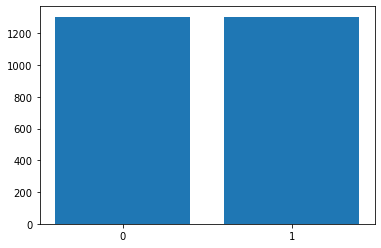

In [17]:
data = dict(Counter(y_train))
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

- SMOTE: KNN처럼 인근 데이터 포인트 잡아서 변동성 고려하여, 사이에 새로운 관측치들을 샘플링.(거리를 scaling 한 이유)

- 이외에도 다양한 방법들이 있음 => roc curve minimizing or stratified cross validation

In [18]:
x_train_scaled.columns = x_train.columns
x_test_scaled.columns = x_test.columns

# 3. Logistic Regression

## (1) all variables

In [85]:
log_clf1 = sm.Logit(y_train,x_train_scaled)

classifier1 = log_clf1.fit()

Optimization terminated successfully.
         Current function value: 0.388358
         Iterations 32


In [86]:
print(classifier1.summary2())

                                       Results: Logit
Model:                        Logit                     Pseudo R-squared:          0.440    
Dependent Variable:           y                         AIC:                       2087.2292
Date:                         2021-12-01 12:26          BIC:                       2263.2423
No. Observations:             2610                      Log-Likelihood:            -1013.6  
Df Model:                     29                        LL-Null:                   -1809.1  
Df Residuals:                 2580                      LLR p-value:               0.0000   
Converged:                    1.0000                    Scale:                     1.0000   
No. Iterations:               32.0000                                                       
--------------------------------------------------------------------------------------------
                         Coef.     Std.Err.      z     P>|z|       [0.025         0.975]    
----------------

In [87]:
LR = LogisticRegression()

# K-Fold Validation
kfold = 10

# ACC Score
LR_cv_results_acc = cross_val_score(LR, x_train_scaled, y_train, cv=kfold, scoring='roc_auc')   
msg = "%s k-fold AUC: %f (%f)" % ('LR', LR_cv_results_acc.mean(), LR_cv_results_acc.std())
print(msg)

LR k-fold AUC: 0.900822 (0.010561)


## (2) variable selection 

In [88]:
to_remove = ['Kidhome','Teenhome','Children', 'Family_Size','Income','MntSweetProducts', 'MntFruits', 'Dt_Customer_long', 'Complain', 'MntGoldProds']
x_logit = x_train_scaled.drop(to_remove, axis=1)
x_logit_test = x_test_scaled.drop(to_remove, axis=1)

In [89]:
log_clf2 =sm.Logit(y_train,x_logit)

classifier2 = log_clf2.fit()

Optimization terminated successfully.
         Current function value: 0.405257
         Iterations 7


In [90]:
print(classifier2.summary2())

                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.415      
Dependent Variable:   y                  AIC:                2159.4432  
Date:                 2021-12-01 12:26   BIC:                2288.5196  
No. Observations:     2610               Log-Likelihood:     -1057.7    
Df Model:             21                 LL-Null:            -1809.1    
Df Residuals:         2588               LLR p-value:        8.8367e-306
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       7.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Recency                 -3.5303   0.2276 -15.5117 0.0000 -3.9764 -3.0842
MntWines                -1.9970   0.4717  -4.2332 0.0000 -2.9216 -1.0724
MntMeat

- 로지스틱 모형의 장점: 해석

- 음의 영향 주요 변수: Recency, NumStorePurchases, Dt_Customer_recent 

- 구매 후 일수가 오래 지날수록 캠페인 참여 줄어든다. Store에서 구매하는 횟수가 많을수록 캠페인 참여 줄어든다. 최근에 가입할수록 캠페인 응답 X

- 양의 영향 주요 변수: MntMeatProducts, NumCatalogPurchases, NumWebPurchases

- 육류소비가 많은 고객과 Catalog, Web에서 구매하는 횟수가 많을수록 캠페인 참여 오즈비 증가. 

In [91]:
LR = LogisticRegression()

# K-Fold Validation
kfold = 10

# ACC Score
LR_cv_results_acc = cross_val_score(LR, x_logit, y_train, cv=kfold, scoring='roc_auc')   
msg = "%s k-fold AUC: %f (%f)" % ('LR', LR_cv_results_acc.mean(), LR_cv_results_acc.std())
print(msg)

LR k-fold AUC: 0.892443 (0.010170)


- backward selection을 사용한 logistic regression: 아주 약간 AUC 면적 감소

# 4. Adaboost

In [95]:
param_grid = {
    "learning_rate" : [0.1, 0.4, 0.7, 1, 1.3, 1.6],
    "base_estimator__max_depth" : [1, 5, 10, 15, 20, 25],
    "n_estimators": [100, 200, 300, 400, 500, 600]
             }

# Validation for Boosting Tree
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=20211126)  

# run grid search
grid_search_clf = GridSearchCV(clf, param_grid=param_grid, scoring = 'roc_auc', cv=kfold)

In [96]:
grid_search_clf.fit(x_train_scaled,y_train)

GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=20211126),
             param_grid={'base_estimator__max_depth': [1, 5, 10, 15, 20, 25],
                         'learning_rate': [0.1, 0.4, 0.7, 1, 1.3, 1.6],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             scoring='roc_auc')

In [97]:
print(grid_search_clf.best_params_) 
print(grid_search_clf.best_score_)

{'base_estimator__max_depth': 15, 'learning_rate': 0.4, 'n_estimators': 600}
0.9825954198473283


In [102]:
param_grid = {
    "learning_rate" : [0.4],
    "base_estimator__max_depth" : [15],
    "n_estimators": [600, 800, 1000, 1200, 1400, 1600]
             }

# Validation for Boosting Tree
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=20211126)  

# run grid search
grid_search_clf = GridSearchCV(clf, param_grid=param_grid, scoring = 'roc_auc', cv=kfold)

In [103]:
grid_search_clf.fit(x_train_scaled,y_train)

GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=20211126),
             param_grid={'base_estimator__max_depth': [15],
                         'learning_rate': [0.4],
                         'n_estimators': [600, 800, 1000, 1200, 1400, 1600]},
             scoring='roc_auc')

In [104]:
print(grid_search_clf.best_params_) 
print(grid_search_clf.best_score_)

{'base_estimator__max_depth': 15, 'learning_rate': 0.4, 'n_estimators': 600}
0.9825954198473283


In [182]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15), learning_rate=0.4, n_estimators=600, random_state=20211126)  

In [183]:
clf.fit(x_train_scaled,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15),
                   learning_rate=0.4, n_estimators=600, random_state=20211126)

## 5. SVM

## (1) all variables

In [113]:
SVM=svm.SVC(kernel = 'rbf')
param_grid = {'gamma': [0.1, 0.5, 1, 2, 4],
                 'C' : [0.5, 1, 2.5, 5, 7.5, 10]}
grid = GridSearchCV(SVM, param_grid=param_grid, 
                    scoring=['roc_auc'], refit='roc_auc',
                    return_train_score=True, cv=kfold)

In [114]:
grid.fit(x_train_scaled, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.5, 1, 2.5, 5, 7.5, 10],
                         'gamma': [0.1, 0.5, 1, 2, 4]},
             refit='roc_auc', return_train_score=True, scoring=['roc_auc'])

In [115]:
print(grid.best_params_) 
print(grid.best_score_) 

{'C': 7.5, 'gamma': 2}
0.986699941280094


In [136]:
SVMmodel1=svm.SVC(kernel = 'rbf', gamma=2, C=7.5, random_state=20211126, probability=True)

In [137]:
SVMmodel1.fit(x_train_scaled, y_train)

SVC(C=7.5, gamma=2, probability=True, random_state=20211126)

## (2) variable selection1: using logistic regression coeff

- 비선형 서포트 벡터 머신에 피쳐 선택을 사용하는 것은 일반적으로 좋지 않은 아이디어라고 생각된다. 일반적으로 피쳐 선택을 위한 노력이 일반화 성능을 저하시킨다는 것. 따라서, logistic regression 결과에 의한 coefficient로 비교하고자 함. 

In [168]:
SVM=svm.SVC(kernel = 'rbf')
param_grid = {'gamma': [0.5, 1, 2, 4, 6, 8],
                 'C' : [0.5, 1, 2.5, 5, 7.5, 10]}
grid = GridSearchCV(SVM, param_grid=param_grid, 
                    scoring=['roc_auc'], refit='roc_auc',
                    return_train_score=True, cv=kfold)

In [169]:
grid.fit(x_logit, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.5, 1, 2.5, 5, 7.5, 10],
                         'gamma': [0.5, 1, 2, 4, 6, 8]},
             refit='roc_auc', return_train_score=True, scoring=['roc_auc'])

In [170]:
print(grid.best_params_) 
print(grid.best_score_) 

{'C': 5, 'gamma': 6}
0.9818379330593071


In [171]:
SVMmodel2=svm.SVC(kernel = 'rbf', gamma=6, C=5, random_state=20211126, probability=True)

In [173]:
SVMmodel2.fit(x_logit, y_train)

SVC(C=5, gamma=6, probability=True, random_state=20211126)

# 6. test set performance

## (1) Logistic: all variables

In [92]:
pred1 = classifier1.predict(x_test_scaled)
roc_auc_score(y_test, pred1)

0.9062283869976178

## (2) Logistic: variable selection

In [94]:
pred2 = classifier2.predict(x_logit_test)
roc_auc_score(y_test, pred2)

0.9098977945131791

## (3) Adaboost

In [185]:
roc_auc_score(y_test, clf.predict(x_test_scaled))

0.7007992007992008

## (4) SVM: all variables

In [139]:
roc_auc_score(y_test, SVMmodel1.predict(x_test_scaled))

0.6542207792207793

## (5) SVM: variable selection

In [179]:
roc_auc_score(y_test, SVMmodel2.predict(x_logit_test))

0.6449800199800201

# 7. ROC curve comparision

In [187]:
pred = classifier.predict(x_logit_test)
pred1 = clf.predict_proba(x_test_scaled)
pred2 = SVMmodel1.predict_proba(x_test_scaled)

In [188]:
fper, tper, thresholds = roc_curve(y_test, pred)
pred1 = pred1[:,1]
fper1, tper1, thresholds1 = roc_curve(y_test, pred1)
pred2 = pred2[:,1]
fper2, tper2, thresholds2 = roc_curve(y_test, pred2)

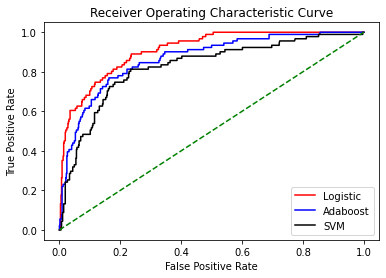

In [189]:
plt.plot(fper, tper, color='red', label='Logistic')
plt.plot(fper1, tper1, color='blue', label='Adaboost')
plt.plot(fper2, tper2, color='black', label='SVM')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

# 8. Confusion Matrix

In [191]:
predictions1 = np.zeros(663)
predictions2 = np.zeros(663)
predictions3 = np.zeros(663)
predictions1[pred>0.5] = 1
predictions1[pred <= 0.5] = 0
predictions2[pred>0.7] = 1
predictions2[pred <= 0.7] = 0
predictions3[pred>0.9] = 1
predictions3[pred <= 0.9] = 0

In [192]:
print('Test ACC: ', accuracy_score(predictions1, y_test)) # cut_off:0.5
print(classification_report(y_test, predictions1))

Test ACC:  0.8280542986425339
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       572
           1       0.43      0.79      0.56        91

    accuracy                           0.83       663
   macro avg       0.70      0.81      0.73       663
weighted avg       0.89      0.83      0.85       663



In [193]:
print('Test ACC: ', accuracy_score(predictions2, y_test)) # cut_off:0.7
print(classification_report(y_test, predictions2))

Test ACC:  0.8883861236802413
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       572
           1       0.58      0.66      0.62        91

    accuracy                           0.89       663
   macro avg       0.76      0.79      0.78       663
weighted avg       0.89      0.89      0.89       663



In [194]:
print('Test ACC: ', accuracy_score(predictions3, y_test)) # cut_off:0.9
print(classification_report(y_test, predictions3))

Test ACC:  0.9079939668174962
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       572
           1       0.83      0.42      0.55        91

    accuracy                           0.91       663
   macro avg       0.87      0.70      0.75       663
weighted avg       0.90      0.91      0.89       663



- precision: 예측 한 것이 실제 맞는 경우.
- recall: 실제 target 값을 예측이 맞추는 경우.

- 원하는 목표에 맞춰서 cut-off value를 설정할 수 있다. 

- 실제 1인 것들에 대해서 보수적으로 잘 맞춰주는 게 중요하다면, 0.5 (최대한 많은 고객으로부터 캠페인 이끌어내기)
- 1로 예측한 것들이 잘 맞추는 것이 중요하다면, 0.9 (비용절감)

In [195]:
y_test.value_counts()

0    572
1     91
Name: Response, dtype: int64

In [98]:
572/(572+91)

0.8627450980392157

- stupid classifier에 비해 월등한 성능을 보이지는 않지만, 주 관심이 캠페인에 참여할 고객의 특성을 파악하는 것이기 때문에, 어느정도 의미있는 classification 결과라고 할 수 있다. 